#Topic: Analyzing Enrollment Data for the Math and CSE Departments
##Course MATH 189
##Semester: Spring 2024
##Name and PID : Daniel Tran A17578274, Yihe Tian A16633212, Runshi Wang A17570995


# We have used Chat GPT to help assist in figuring out how to create some of our code.

The libaries we used for our project:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import sklearn.linear_model
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Cleaning and Description of data:

Data reading and data cleaning for our data.

In [ ]:
df_5_16 = pd.read_csv('/content/Spring 2-16.csv')
df_3_1 = pd.read_csv('/content/Spring 3-1.csv')
df_2_22 = pd.read_csv('/content/Spring 2-22.csv')
df_2_21 = pd.read_csv('/content/Spring 2-21.csv')
df_2_16 = pd.read_csv('//content/Spring 2-16.csv')
#df_5_16 = pd.read_csv('/content/drive/MyDrive/Math 189 Project/Enrollment Data/Spring 2-21.csv')
#df_3_1 = pd.read_csv('/content/drive/MyDrive/Math 189 Project/Enrollment Data/Spring 3-1.csv')
#df_2_21 = pd.read_csv('/content/drive/MyDrive/Math 189 Project/Enrollment Data/Spring 2-21.csv')
#df_2_16 = pd.read_csv('/content/drive/MyDrive/Math 189 Project/Enrollment Data/Spring 2-16.csv')
# Merge the four df to a big df named Big_df



Big_df = pd.concat([df_2_16,df_2_21, df_3_1, df_5_16], axis=0, ignore_index=True)

# add Quarter Column and extract the department from 'subj_course_id'
Big_df['quarter'] = 'Spring2023'
Big_df['department'] = Big_df['subj_course_id'].str.extract(r'([A-Za-z]+)')

# Math upper df (drop course number & course section(id) )
Mathdf = Big_df[Big_df['department'] == 'MATH'].copy()
Mathdf['course_number_int'] = Mathdf['subj_course_id'].str.extract(r'(\d+)', expand=False).astype(float)
Upper_Math = Mathdf[(Mathdf['course_number_int'] >= 100) & (Mathdf['course_number_int'] < 200)].copy()
Lower_Math = Mathdf[(Mathdf['course_number_int'] < 100)].copy()
Upper_Math.drop(columns=['course_number_int', 'sec_code', 'sec_id'], inplace=True)

# CSE upper df (drop course number & course section(id) )
CSEdf = Big_df[Big_df['department'] == 'CSE'].copy()
CSEdf['course_number_int'] = CSEdf['subj_course_id'].str.extract(r'(\d+)', expand=False).astype(float)
Upper_CSE = CSEdf[(CSEdf['course_number_int'] >= 100) & (CSEdf['course_number_int'] < 200)].copy()
Lower_CSE = CSEdf[(CSEdf['course_number_int'] < 100)].copy()
Upper_CSE.drop(columns=['course_number_int', 'sec_code', 'sec_id'], inplace=True)

# Combine Upper_Math and Upper_CSE
spdf = pd.concat([Upper_Math, Upper_CSE, Lower_Math, Lower_CSE], axis=0, ignore_index=True)
spdf['course_number_int'] = spdf['subj_course_id'].str.extract(r'(\d+)').astype(float)
spdf

# Correct 'available' and 'total' values
spdf.loc[spdf['available'] > 5000, 'available'] = 0
spdf.loc[spdf['total'] > 5000, 'total'] = 0

# Correct time column
spdf['time'] = pd.to_datetime(spdf['time'], unit='ms')

Cleaning the data so that we do not have classes with duplicate names.

In [ ]:
#combinding course names with the same exact professor
spdf['date'] = spdf['time'].dt.date
combined_df = spdf.groupby(['date', 'subj_course_id', 'prof', 'department']).agg({
    'available': 'mean',
    'waitlist': 'mean',
    'total': 'mean',
    'enrolled_ct': 'mean'
}).reset_index()
combined_df['date'] = pd.to_datetime(combined_df['date'])

def enrollment_stage(date):
    if date <= pd.to_datetime('2023-02-16'):
        return 'Before 1st Pass'
    elif date <= pd.to_datetime('2023-02-21'):
        return 'During 1st Pass'
    elif date <= pd.to_datetime('2023-03-01'):
        return 'During 2nd Pass'
    else:
        return 'After 2nd Pass'

combined_df['enrollment_stage'] = combined_df['date'].apply(enrollment_stage)
combined_df['course_number'] = combined_df['subj_course_id'].str.extract(r'(\d+)').astype(int)

combined_df

,date,subj_course_id,prof,department,available,waitlist,total,enrolled_ct,enrollment_stage,course_number
0,2023-02-16,CSE 100,Sahoo; Debashis,CSE,125.0,0.000000,125.0,0.00,Before 1st Pass,100
1,2023-02-16,CSE 100R,Sahoo; Debashis,CSE,125.0,0.000000,125.0,0.00,Before 1st Pass,100
2,2023-02-16,CSE 101,Jones; Miles E,CSE,150.0,0.000000,150.0,0.00,Before 1st Pass,101
3,2023-02-16,CSE 105,Grier; Daniel T,CSE,50.0,0.000000,50.0,0.00,Before 1st Pass,105
4,2023-02-16,CSE 105,Minnes Kemp; Mor Mia,CSE,273.0,0.000000,273.0,0.00,Before 1st Pass,105
...,...,...,...,...,...,...,...,...,...,...
689,2023-03-02,MATH 31CH,Izadi; Elham,MATH,31.0,0.000000,37.0,6.00,After 2nd Pass,31
690,2023-03-02,MATH 3C,Aycock; Jon Merrill,MATH,0.0,1.357143,2.0,2.25,After 2nd Pass,3
691,2023-03-02,MATH 4C,Aliabadi Sr.; Mohsen,MATH,20.5,0.000000,35.0,14.50,After 2nd Pass,4
692,2023-03-02,MATH 87,Stevens; Laura Jeanne,MATH,11.0,0.000000,20.0,9.00,After 2nd Pass,87


# Basic EDA below:

In [ ]:
first_pass_df = combined_df[combined_df['enrollment_stage'] == 'During 1st Pass']
second_pass_df = combined_df[combined_df['enrollment_stage'] == 'During 2nd Pass']
after_second_pass_df = combined_df[combined_df['enrollment_stage'] == 'After 2nd Pass'].copy()

math_available = first_pass_df[(first_pass_df['department'] == 'MATH') & (first_pass_df['available'] > 0)].shape[0]
cse_available = first_pass_df[(first_pass_df['department'] == 'CSE') & (first_pass_df['available'] > 0)].shape[0]
math_available_2nd = second_pass_df[(second_pass_df['department'] == 'MATH') & (second_pass_df['available'] > 0)].shape[0]
cse_available_2nd = second_pass_df[(second_pass_df['department'] == 'CSE') & (second_pass_df['available'] > 0)].shape[0]
math_availableDN = after_second_pass_df[(after_second_pass_df['department'] == 'MATH') & (after_second_pass_df['available'] > 0)].shape[0]
cse_availableDN = after_second_pass_df[(after_second_pass_df['department'] == 'CSE') & (after_second_pass_df['available'] > 0)].shape[0]


print("Number of classes with open seats after seniors and priority enrollment for Math classes during first pass:",math_available)
print("Number of classes with open seats after seniors and priority enrollment for CSE classe during first pass:",cse_available)
print("Number of classes with open seats after seniors and priority enrollment for Math classes during second pass:",math_available_2nd)
print("Number of classes with open seats after seniors and priority enrollment for CSE classes during second pass:",cse_available_2nd)
print("Number of classes with open seats for Math classes after enrollment closes:",math_availableDN)
print("Number of classes with open seats for CSE classes after enrollment closes:",cse_availableDN)

Number of classes with open seats after seniors and priority enrollment for Math classes during first pass: 119
Number of classes with open seats after seniors and priority enrollment for CSE classe during first pass: 100
Number of classes with open seats after seniors and priority enrollment for Math classes during second pass: 96
Number of classes with open seats after seniors and priority enrollment for CSE classes during second pass: 88
Number of classes with open seats for Math classes after enrollment closes: 42
Number of classes with open seats for CSE classes after enrollment closes: 44


#### The purpose of the EDA above was to highlight the difference between the classes that still have open seats during different stages of enrollment. Based off our data the average trend is that the classes within the Math department generally have open seats throughout enrollment.

In [ ]:
lower_division_available_first = first_pass_df[(first_pass_df['course_number'] >= 1) & (first_pass_df['course_number'] <= 99) & (first_pass_df['available'] > 0)].shape[0]
upper_division_available_first = first_pass_df[(first_pass_df['course_number'] >= 100) & (first_pass_df['course_number'] <= 199) & (first_pass_df['available'] > 0)].shape[0]

lower_division_available_second = second_pass_df[(second_pass_df['course_number'] >= 1) & (second_pass_df['course_number'] <= 99) & (second_pass_df['available'] > 0)].shape[0]
upper_division_available_second = second_pass_df[(second_pass_df['course_number'] >= 100) & (second_pass_df['course_number'] <= 199) & (second_pass_df['available'] > 0)].shape[0]
lower_division_available_DN = after_second_pass_df[(after_second_pass_df['course_number'] >= 1) & (after_second_pass_df['course_number'] <= 99) & (after_second_pass_df['available'] > 0)].shape[0]
upper_division_available_DN = after_second_pass_df[(after_second_pass_df['course_number'] >= 100) & (after_second_pass_df['course_number'] <= 199) & (after_second_pass_df['available'] > 0)].shape[0]

print("Number of lower division classes with open seats during first pass:", lower_division_available_first)
print("Number of lower division classes with open seats during second pass:", lower_division_available_second)
print("Number of upper division classes with open seats during first pass:", upper_division_available_first)
print("Number of upper division classes with open seats during second pass:", upper_division_available_second)
print("Number of lower division classes with open seats after enrollment closes:",lower_division_available_DN)
print("Number of upper division classes with open seats after enrollment closes:",upper_division_available_DN)

Number of lower division classes with open seats during first pass: 76
Number of lower division classes with open seats during second pass: 65
Number of upper division classes with open seats during first pass: 143
Number of upper division classes with open seats during second pass: 119
Number of lower division classes with open seats after enrollment closes: 31
Number of upper division classes with open seats after enrollment closes: 55


### This part of EDA was to to see if there was a general difference between upper and lower division classes and the amount of open seats for each class during aeach stage of enrollment. The general trend suggests that upper division classes generally have ore open seats throughout all stages of enrollment. We predict that this is just due to the fact that the upper division classes require lower division classes and because our data focuses on enrollment for juniors, sophomores, and first years there would obviously be more open seats for lower division classes during these stages of enrollment due do many of these students completing their prerequisites.

In [ ]:
fsMerge = pd.merge(first_pass_df, second_pass_df, on=['subj_course_id', 'prof'], suffixes=('_first', '_second'))
increased_seats_df = fsMerge[fsMerge['total_second'] > fsMerge['total_first']]

fsMathIncrease = increased_seats_df[increased_seats_df['department_first'] == 'MATH'].shape[0]
fsCseIncrease = increased_seats_df[increased_seats_df['department_first'] == 'CSE'].shape[0]

fsIncreasedSeatsMath = increased_seats_df[increased_seats_df['department_first'] == 'MATH']['total_second'] - increased_seats_df[increased_seats_df['department_first'] == 'MATH']['total_first']
fsIncreasedSeatsCse = increased_seats_df[increased_seats_df['department_first'] == 'CSE']['total_second'] - increased_seats_df[increased_seats_df['department_first'] == 'CSE']['total_first']

fsIncreasedSeatsMathTotal = round(fsIncreasedSeatsMath.sum())
fsIncreasedSeatsCseTotal = round(fsIncreasedSeatsCse.sum())

print("The amount of classes where total number of seats expanded for Math before second pass ended:", fsMathIncrease)
print("The amount of classes where total number of seats expanded for CSE before second pass ended:", fsCseIncrease)
print("The total number of seats increased for Math before second pass ended:", fsIncreasedSeatsMathTotal)
print("The total number of seats increased for CSE before second pass ended:", fsIncreasedSeatsCseTotal)

The amount of classes where total number of seats expanded for Math before second pass ended: 0
The amount of classes where total number of seats expanded for CSE before second pass ended: 5
The total number of seats increased for Math before second pass ended: 0
The total number of seats increased for CSE before second pass ended: 98


### In this section of our code we aim to see if either the Math and CSE departments would expand course size for some of their more popular classes during enrollment. From our data we can see that the CSE department had expanded the seat size for 5 of their classes which resulted in a 98 seat increase.

In [ ]:
increased_seats_df = increased_seats_df.copy()
increased_seats_df.loc[:, 'course_number'] = increased_seats_df['subj_course_id'].str.extract(r'(\d+)').astype(int)
upper_division_courses = increased_seats_df[(increased_seats_df['course_number'] >= 100) & (increased_seats_df['course_number'] <= 199)]
lower_division_courses = increased_seats_df[(increased_seats_df['course_number'] >= 1) & (increased_seats_df['course_number'] <= 99)]
fsUpperIncrease = upper_division_courses.shape[0]
fsLowerIncrease = lower_division_courses.shape[0]
fsIncreasedSeatsUpper = upper_division_courses['total_second'] - upper_division_courses['total_first']
fsIncreasedSeatsLower = lower_division_courses['total_second'] - lower_division_courses['total_first']
fsIncreasedSeatsUpperTotal = round(fsIncreasedSeatsUpper.sum())
fsIncreasedSeatsLowerTotal = round(fsIncreasedSeatsLower.sum())

print("The total number of seats increased for lower division courses before second pass ended:", fsIncreasedSeatsLowerTotal)
print("The total number of seats increased for upper division courses before second pass ended:", fsIncreasedSeatsUpperTotal)


The total number of seats increased for lower division courses before second pass ended: 0
The total number of seats increased for upper division courses before second pass ended: 98


### In this section we are doing something similar to the previous section but we aim to see which division of classes these departments open additional seats for and from our data we can conclude that the CSE department released all of their extra seats to upper division courses.

In [ ]:
second_pass_df.loc[:, 'date'] = pd.to_datetime(second_pass_df['date'])
after_second_pass_df.loc[:, 'date'] = pd.to_datetime(after_second_pass_df['date'])

spMerge = pd.merge(second_pass_df, after_second_pass_df, on=['subj_course_id', 'prof','course_number'], suffixes=('_first', '_second'))
spIncreasedSeats_df = spMerge[spMerge['total_second'] > spMerge['total_first']]

upper_division_courses = spIncreasedSeats_df[(spIncreasedSeats_df['course_number'] >= 100) & (spIncreasedSeats_df['course_number'] <= 199)]
lower_division_courses = spIncreasedSeats_df[(spIncreasedSeats_df['course_number'] >= 1) & (spIncreasedSeats_df['course_number'] <= 99)]

spUpperIncrease = upper_division_courses.shape[0]
spLowerIncrease = lower_division_courses.shape[0]

spMathIncrease = spIncreasedSeats_df[spIncreasedSeats_df['department_first'] == 'MATH'].shape[0]
spCseIncrease = spIncreasedSeats_df[spIncreasedSeats_df['department_first'] == 'CSE'].shape[0]

spIncreasedSeatsMath = spIncreasedSeats_df[spIncreasedSeats_df['department_first'] == 'MATH']['total_second'] - spIncreasedSeats_df[spIncreasedSeats_df['department_first'] == 'MATH']['total_first']
spIncreasedSeatsCse = spIncreasedSeats_df[spIncreasedSeats_df['department_first'] == 'CSE']['total_second'] - spIncreasedSeats_df[spIncreasedSeats_df['department_first'] == 'CSE']['total_first']

spIncreasedSeatsUpper = upper_division_courses['total_second'] - upper_division_courses['total_first']
spIncreasedSeatsLower = lower_division_courses['total_second'] - lower_division_courses['total_first']

spIncreasedSeatsUpperTotal = round(spIncreasedSeatsUpper.sum())
spIncreasedSeatsLowerTotal = round(spIncreasedSeatsLower.sum())

spIncreasedSeatsMathTotal = round(spIncreasedSeatsMath.sum())
spIncreasedSeatsCseTotal = round(spIncreasedSeatsCse.sum())
print("The amount of classes where total number of seats expanded for Math after second pass ended:", spMathIncrease)
print("The amount of classes where total number of seats expanded for CSE after second pass ended:", spCseIncrease)
print("The total number of seats increased for Math after second pass ended:", spIncreasedSeatsMathTotal)
print("The total number of seats increased for CSE after second pass ended:", spIncreasedSeatsCseTotal)
print("The amount of classes where total number of seats expanded for Lower Division after second pass ended:", spLowerIncrease)
print("The amount of classes where total number of seats expanded for Upper Division after second pass ended:", spUpperIncrease)
print("The total number of seats increased for Lower Division after second pass ended:", spIncreasedSeatsLowerTotal)
print("The total number of seats increased for Upper Division after second pass ended:", spIncreasedSeatsUpperTotal)

The amount of classes where total number of seats expanded for Math after second pass ended: 0
The amount of classes where total number of seats expanded for CSE after second pass ended: 2
The total number of seats increased for Math after second pass ended: 0
The total number of seats increased for CSE after second pass ended: 91
The amount of classes where total number of seats expanded for Lower Division after second pass ended: 0
The amount of classes where total number of seats expanded for Upper Division after second pass ended: 2
The total number of seats increased for Lower Division after second pass ended: 0
The total number of seats increased for Upper Division after second pass ended: 91


### In this section we want to see how many classes where seats had been expanded per department and how many additional seats per department had increased at towards the end of the enrollment stage. Based off of our data we can see that even though the Math department had increased seats for more of their classes, they had released a smaller total amount of seats compared to the CSE department.Similarly, we can also see that towards the end of enrollment the number of classes where the total number of seats increased for the the upper and lower division courses had increased however upper division classes had expanded less compared to lower division classes.

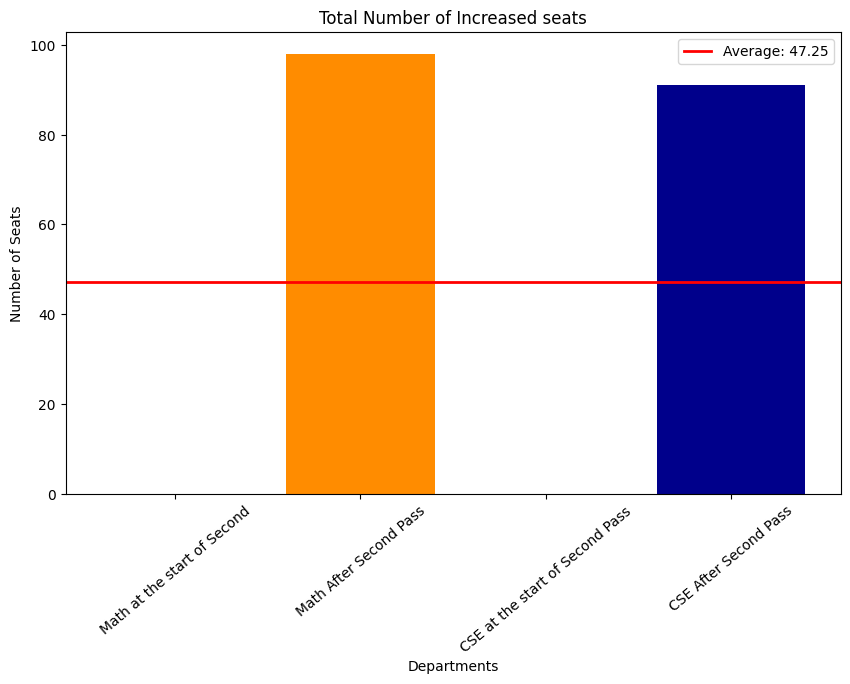

In [ ]:
labels = ['Math at the start of Second', 'Math After Second Pass', 'CSE at the start of Second Pass', 'CSE After Second Pass']
values = [fsIncreasedSeatsMathTotal, fsIncreasedSeatsCseTotal, spIncreasedSeatsMathTotal, spIncreasedSeatsCseTotal]
colors = ['orange', 'darkorange', 'blue', 'darkblue']
average_value = sum(values) / len(values)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=colors)
plt.xlabel('Departments')
plt.ylabel('Number of Seats')
plt.title('Total Number of Increased seats')

plt.axhline(y=average_value, color='red', linestyle='-', linewidth=2, label=f'Average: {average_value:.2f}')
plt.xticks(rotation=40)

# Add legend
plt.legend()
plt.show()

### In this plot we can see that although both departments did end up increasing seats for their classes we can see that the CSE department had increased seats by a great amount during all stages of enrollment with the average number of seats per per stage of enrollment for both deppartments being 628.5 seats with the CSE department increasing seats sometime towards the end of enrollment being the outlier.

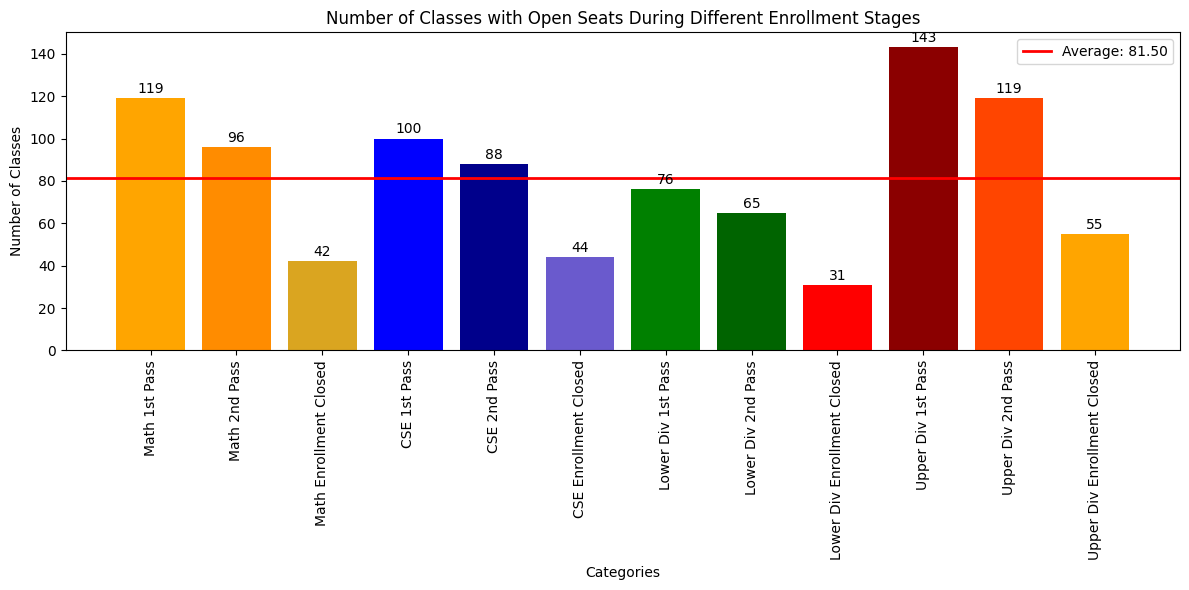

In [ ]:
# Values for plotting
labels = [
    'Math 1st Pass', 'Math 2nd Pass','Math Enrollment Closed', 'CSE 1st Pass', 'CSE 2nd Pass','CSE Enrollment Closed',
    'Lower Div 1st Pass', 'Lower Div 2nd Pass','Lower Div Enrollment Closed', 'Upper Div 1st Pass', 'Upper Div 2nd Pass', 'Upper Div Enrollment Closed'
]
values = [
    math_available, math_available_2nd,math_availableDN , cse_available, cse_available_2nd,
    cse_availableDN,lower_division_available_first, lower_division_available_second,lower_division_available_DN,
    upper_division_available_first, upper_division_available_second, upper_division_available_DN
]

average_value = sum(values) / len(values)

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, values, color=['orange', 'darkorange','goldenrod', 'blue', 'darkblue','slateblue', 'green', 'darkgreen', 'red', 'darkred','orangered'])

plt.xlabel('Categories')
plt.ylabel('Number of Classes')
plt.title('Number of Classes with Open Seats During Different Enrollment Stages')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

# Display the plot
plt.axhline(y=average_value, color='red', linestyle='-', linewidth=2, label=f'Average: {average_value:.2f}')
plt.xticks(rotation=90)
plt.tight_layout()
plt.legend()
plt.show()

#### This plot shows the number of open seats during the different stages of enrollment. From this plot we can clearly see that generally the Math department has more classes with open seats compared to the CSE department and that the upper division has more open seats compared to the lower division classes.

#### From our EDA  we can conclude that generally juniors,sophomores, and first years should prioritize to get CSE classes first over math classes and should also aim to get lower division classes first over the upper division classes if they need these specific classes.

## Statistical Analysis

In this section of our project we aim to test the independence between the enrollment between the two departments and between the upper and lower division classes.

In [ ]:
#testing independence for enrollment between Math and CSE
second_pass_data = combined_df[(combined_df['enrollment_stage'] == 'During 2nd Pass') &
                               (combined_df['department'].isin(['MATH', 'CSE']))].copy()
second_pass_data['has_available_seats'] = second_pass_data['available'] > 0
contigency = pd.crosstab(second_pass_data['department'], second_pass_data['has_available_seats'])
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contigency)

print("Chi-squared Statistic: for the start of second pass", chi2_stat)
print("P-value for the start of second pass:", p_value)
print("Expected Frequencies for the start of second pass:\n", expected)
print()

#doing the same thing for after enrollment closed
after_second_pass_data = combined_df[(combined_df['enrollment_stage'] == 'After 2nd Pass') &
                                     (combined_df['department'].isin(['MATH', 'CSE']))].copy()
after_second_pass_df['has_available_seats'] = after_second_pass_df['available'] > 0

contigency2 = pd.crosstab(after_second_pass_df['department'], after_second_pass_df['has_available_seats'])
chi2_stat1, p_value1, dof1, expected1 = stats.chi2_contingency(contigency2)
print("Chi-squared Statistic: for the end of enrollment", chi2_stat1)
print("P-value for the end of enrollment:", p_value1)
print("Expected Frequencies for the end of enrollment:\n", expected1)

Chi-squared Statistic: for the start of second pass 0.007046588479232766
P-value for the start of second pass: 0.9331009875761173
Expected Frequencies for the start of second pass:
 [[22.75862069 87.24137931]
 [25.24137931 96.75862069]]

Chi-squared Statistic: for the end of enrollment 1.3381966057833385
P-value for the end of enrollment: 0.24735225093883823
Expected Frequencies for the end of enrollment:
 [[14.22413793 40.77586207]
 [15.77586207 45.22413793]]


Based off of these results we can see that our $P-Value$ for both the start of the second pass and at the end of enrollment are around $0.92$ this shows that the enrollment for both Math and CSE courses are independent of eachother.

Our Frequencies show that between both at the start of second pass and at the end of enrollment you can expect about $23-25$ enrolled students per math class and $87-96$ per CSE class and about $25-27$ enrolled students per Math class and $94-102$ per CSE class which is inline with what we have seen in our own respective classes.

Our Chi-squared statistic tells us that we would want to accept our null hypothesis which confirms that the enrollment between the two departments are independent from eachother.

In [ ]:
#testing independence for enrollment between upper and lower div
# Filter and categorize courses by division


second_pass_data['division'] = second_pass_data['course_number'].apply(lambda x: 'Upper' if x >= 100 else 'Lower')
second_pass_data['has_available_seats'] = second_pass_data['available'] > 0

contingency_upper_lower = pd.crosstab([second_pass_data['department'], second_pass_data['division']],
                                      second_pass_data['has_available_seats'])
chi2_stat_upper_lower, p_value_upper_lower, dof_upper_lower, expected_upper_lower = stats.chi2_contingency(contingency_upper_lower)

print("Chi-squared Statistic: for the start of second pass", chi2_stat_upper_lower)
print("P-value for the start of second pass:", p_value_upper_lower)
print("Expected Frequencies for the start of second pass:\n", expected_upper_lower)
print()


after_second_pass_data['division'] = after_second_pass_data['course_number'].apply(lambda x: 'Upper' if x >= 100 else 'Lower')
after_second_pass_data['has_available_seats'] = after_second_pass_data['available'] > 0

contingency2_upper_lower = pd.crosstab([after_second_pass_data['department'], after_second_pass_data['division']],
                                       after_second_pass_data['has_available_seats'])
chi2_stat1_upper_lower, p_value1_upper_lower, dof1_upper_lower, expected1_upper_lower = stats.chi2_contingency(contingency2_upper_lower)

print("Chi-squared Statistic: for the end of enrollment", chi2_stat1_upper_lower)
print("P-value for the end of enrollment:", p_value1_upper_lower)
print("Expected Frequencies for the end of enrollment:\n", expected1_upper_lower)


Chi-squared Statistic: for the start of second pass 9.26570016923278
P-value for the start of second pass: 0.025959097988102278
Expected Frequencies for the start of second pass:
 [[ 6.62068966 25.37931034]
 [16.13793103 61.86206897]
 [ 9.93103448 38.06896552]
 [15.31034483 58.68965517]]

Chi-squared Statistic: for the end of enrollment 7.691324329696424
P-value for the end of enrollment: 0.052841025735885526
Expected Frequencies for the end of enrollment:
 [[ 4.13793103 11.86206897]
 [10.0862069  28.9137931 ]
 [ 6.20689655 17.79310345]
 [ 9.56896552 27.43103448]]


The chi-squared statistic and the $p-value$ tells us that there is a statistically significant difference for enrollment at the start of the second pass between upper division and lower division course enrollment. The $p-value$ also tells us that we would want to reject our null hypothesis which means that at the start of the second pass these two divisions are not independent of eachother.

Conversely our chi squared statistic and $p-value$ for when enrollment closes tells you that there is no difference meaning that towards the end of enrollment the course enrollment levels for upper and lower division classes normalize or are randomly distributed. This tells us that the enrollment between the two divisions at the end of enrollment are independent of eachother.


# Logistic Regression for Finding the Probability of getting into a Class.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

combined_df['date'] = pd.to_datetime(combined_df['date'])

def classify_course(row):
    if row['department'] == 'MATH':
        if row['course_number'] >= 100:
            return 'upper_div_math'
        else:
            return 'lower_div_math'
    elif row['department'] == 'CSE':
        if row['course_number'] >= 100:
            return 'upper_div_cse'
        else:
            return 'lower_div_cse'

combined_df['course_class'] = combined_df.apply(classify_course, axis=1)

X = combined_df[['total', 'enrolled_ct']]
y = combined_df['course_class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200, class_weight='balanced')
log_reg.fit(X_train, y_train)


y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))


coefficients = pd.DataFrame(log_reg.coef_, columns=X.columns, index=log_reg.classes_)
print(coefficients)

                precision    recall  f1-score   support

 lower_div_cse       0.42      0.24      0.30        34
lower_div_math       0.37      0.67      0.48        46
 upper_div_cse       0.75      0.58      0.65        66
upper_div_math       0.50      0.44      0.47        63

      accuracy                           0.50       209
     macro avg       0.51      0.48      0.48       209
  weighted avg       0.54      0.50      0.50       209

                   total  enrolled_ct
lower_div_cse   0.018256     0.001471
lower_div_math -0.015096    -0.012449
upper_div_cse   0.020822     0.002040
upper_div_math -0.023982     0.008938


Based off of the result, we can see that our precision for lower div CSE is $42\% $ which means that our model stuggled to to predict getting into a lower division CSE class which suggests that it may be hard to get into lower division classes.

Looking at lower division Math we can see that our recall score is high while our precision is low, which suggests that our model was unable to accurately predict if we could get into these classes. This may suggest that the chances of getting into a lower division class has moderate difficulty and that it just depends on the stage of enrollment and the total enrollment for that quarter.

Looking at our upper division CSE stats our model suggests that there is a higher probability of getting into upper division CSE courses as it was able to predict getting in $75\%$ of the time.

Looking at our numbers for upper division Math classes. Our model has a $50\%$ precision and a $0.44$ recall score which suggests that our model was either not able to accurately predict the difficulty of getting into the courses or that there is moderate level difficulty to getting into upper division Math classes.

Judging off of these results we recommend that students should prioritize getting their lower division CSE requirements first as the seats do seem to fill up faster. For upper divsion CSE we suggest that students should enroll into them if they have the chance to but the probability of you getting into one is much higher than lower division CSE.

Conversely with the math department, we suggest that students do try to keep an eye on the classes they would need and try to enroll into these classes first as there may be moderate level difficulty getting into these classes.

With our model we understand that there are outside limiting factors that can have an effect on student enrollment such as professor difficulty, popularity of the course and department priority. We also would like to say that the higher the student standing the higher likelyhood that a student will get in to their desired classes simply due to the fact that higher standing students have earlier enrollment times.

<ipython-input-15-fa4e40defc75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3_1['course_number'] = df_3_1['subj_course_id'].str.extract(r'(\d+)').astype(int)


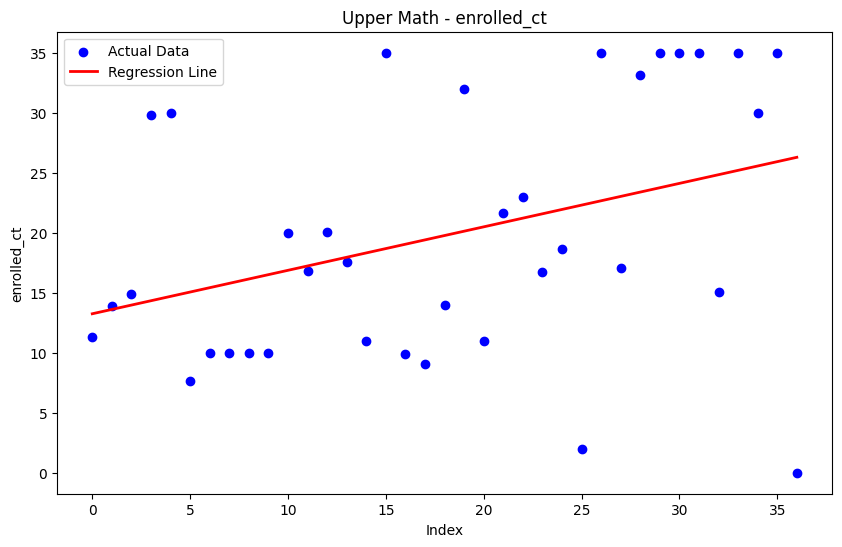

Regression for Upper Math - enrolled_ct: Coefficient = 0.3621735482019415, Intercept = 13.246078835067756


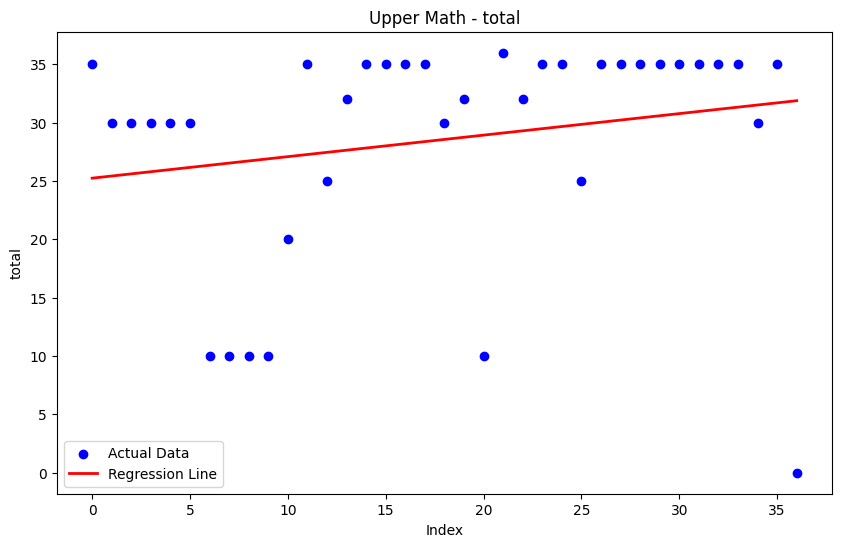

Regression for Upper Math - total: Coefficient = 0.18444760550023706, Intercept = 25.2475106685633


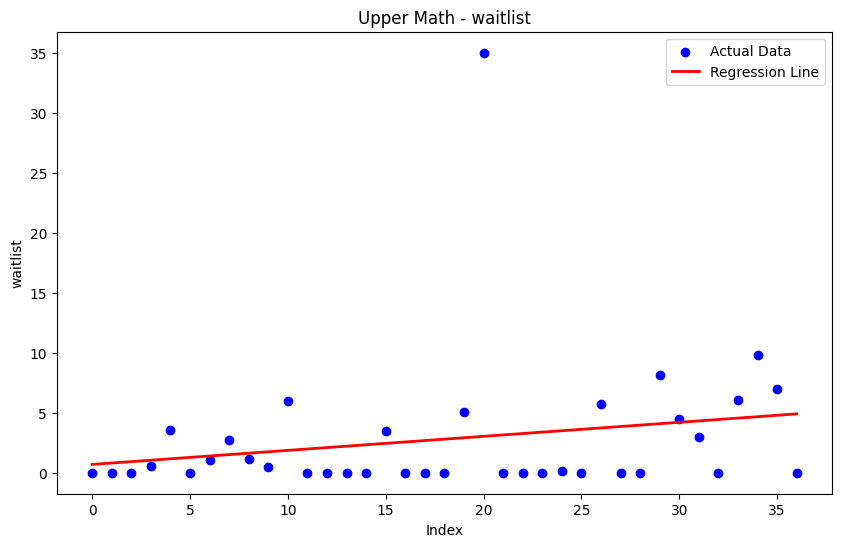

Regression for Upper Math - waitlist: Coefficient = 0.11696374352191524, Intercept = 0.6911794065533683


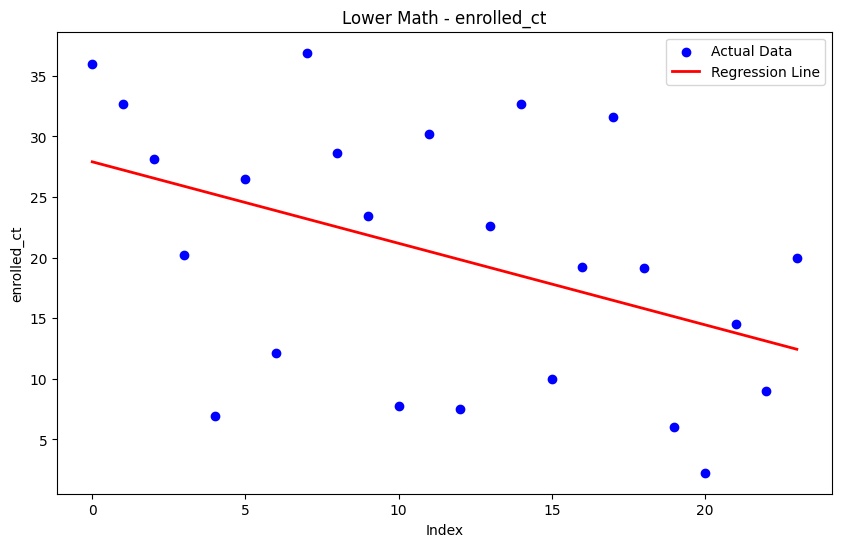

Regression for Lower Math - enrolled_ct: Coefficient = -0.6724359812574915, Intercept = 27.904113883192828


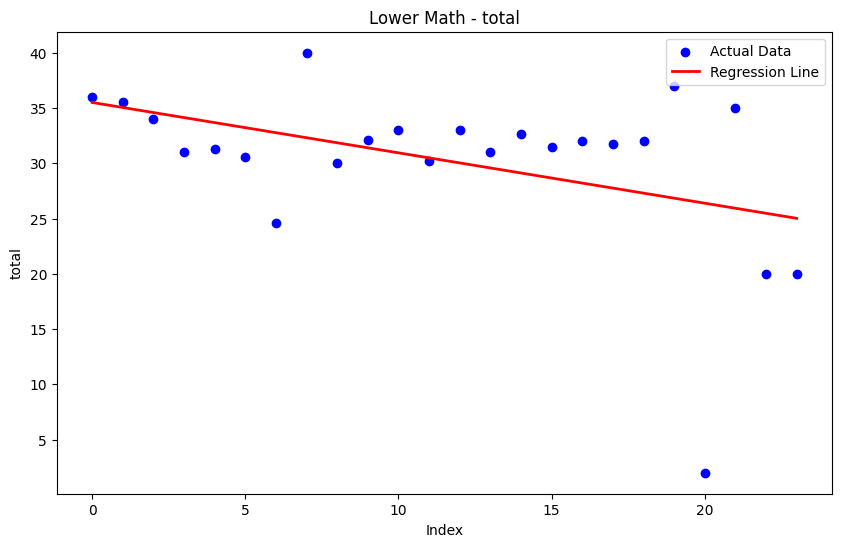

Regression for Lower Math - total: Coefficient = -0.45575051759834356, Intercept = 35.49929292929293


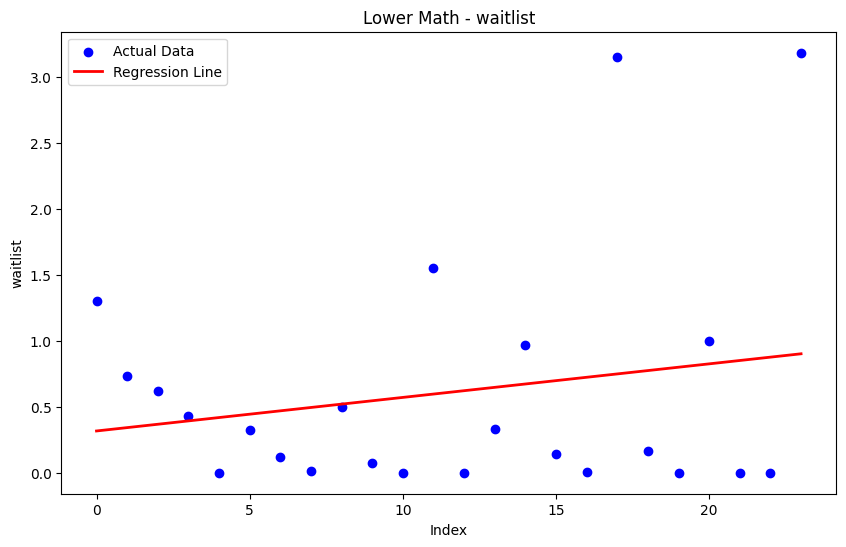

Regression for Lower Math - waitlist: Coefficient = 0.02544153181867712, Intercept = 0.3165420701374649


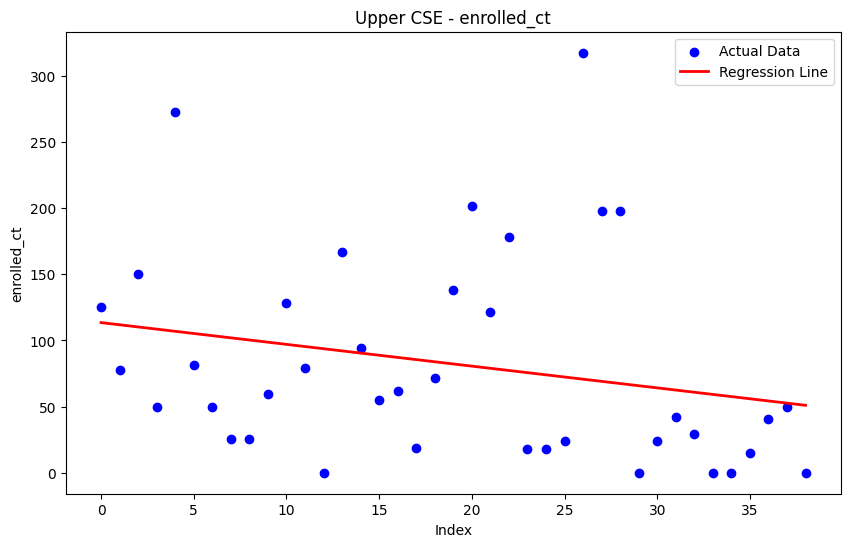

Regression for Upper CSE - enrolled_ct: Coefficient = -1.6450702287094263, Intercept = 113.46882872244716


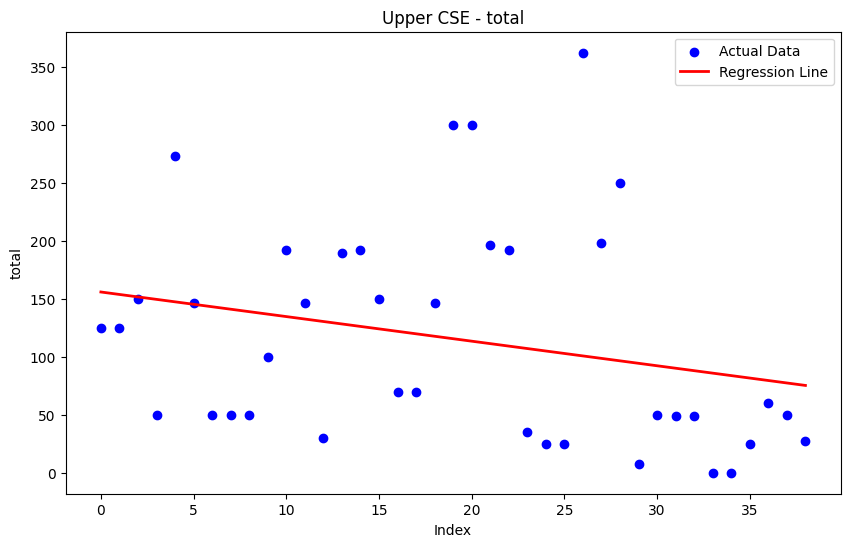

Regression for Upper CSE - total: Coefficient = -2.1195503942041345, Intercept = 155.77381916329287


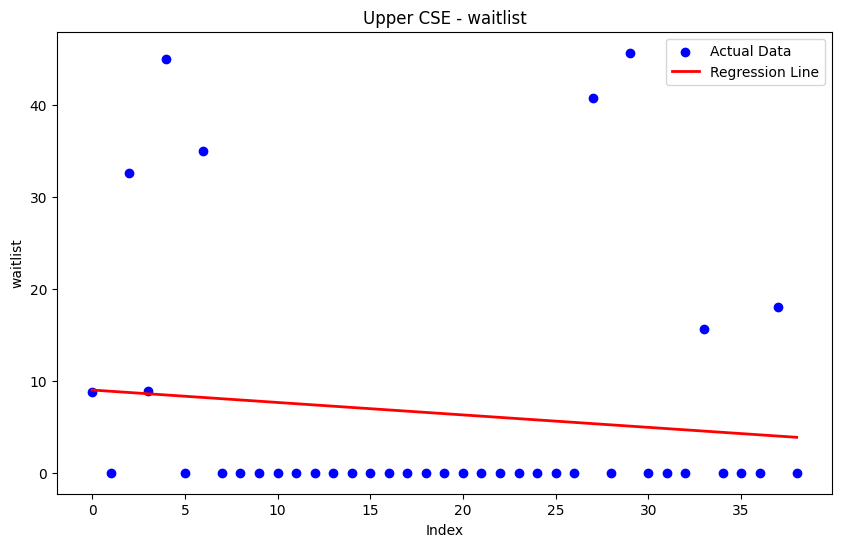

Regression for Upper CSE - waitlist: Coefficient = -0.13530391007884085, Intercept = 8.988959176788125


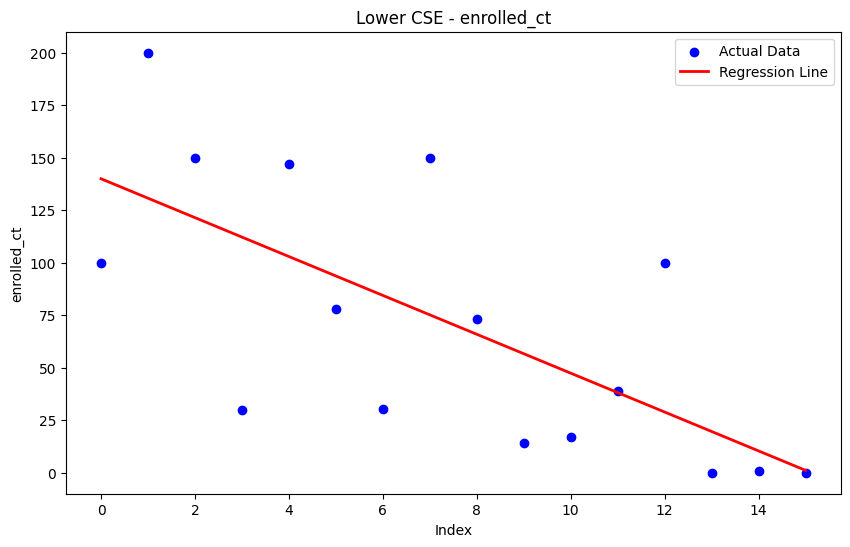

Regression for Lower CSE - enrolled_ct: Coefficient = -9.257475490196072, Intercept = 139.98342363261088


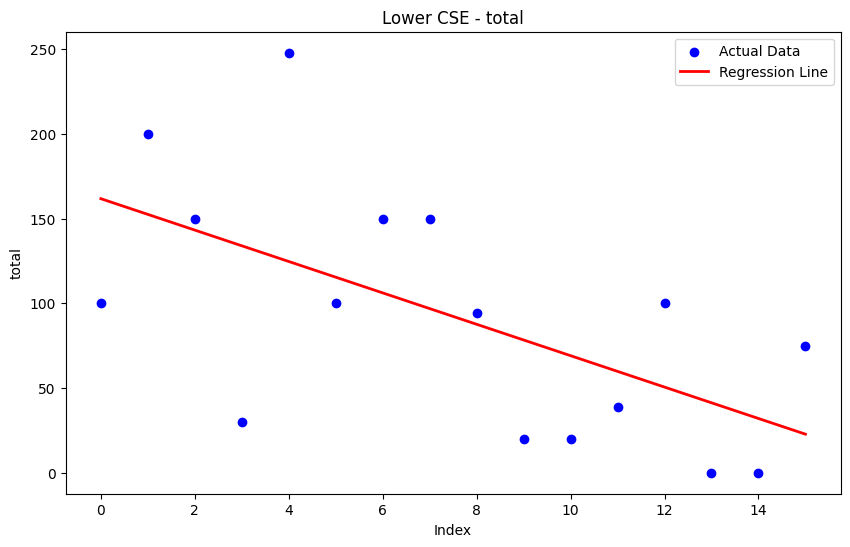

Regression for Lower CSE - total: Coefficient = -9.269852941176467, Intercept = 161.8051470588235


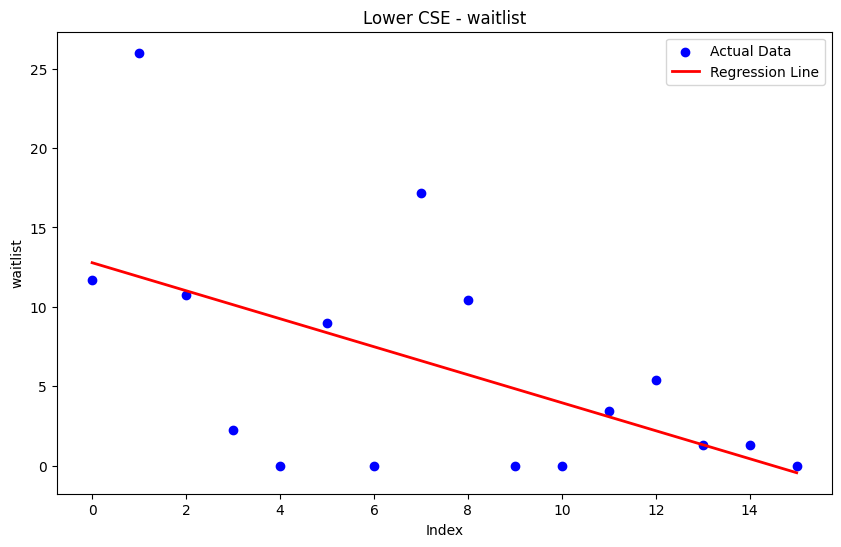

Regression for Lower CSE - waitlist: Coefficient = -0.8814718782249737, Intercept = 12.779240841073268


In [ ]:
combined_df['date'] = pd.to_datetime(combined_df['date'])
df_3_1 = combined_df[combined_df['date'] == pd.to_datetime('2023-03-01')]
df_3_1['course_number'] = df_3_1['subj_course_id'].str.extract(r'(\d+)').astype(int)

upper_math_ND = (df_3_1['department'] == 'MATH') & (df_3_1['course_number'] >= 100) & (df_3_1['course_number'] < 200)
lower_math_ND = (df_3_1['department'] == 'MATH') & (df_3_1['course_number'] < 100)
upper_cse_ND = (df_3_1['department'] == 'CSE') & (df_3_1['course_number'] >= 100) & (df_3_1['course_number'] < 200)
lower_cse_ND = (df_3_1['department'] == 'CSE') & (df_3_1['course_number'] < 100)

# Return the four data frames
upper_math_df = df_3_1[upper_math_ND]
lower_math_df = df_3_1[lower_math_ND]
upper_cse_df = df_3_1[upper_cse_ND]
lower_cse_df = df_3_1[lower_cse_ND]

# Linear Regression
def perform_regression_and_plot(data, column, category):
    if data.empty or data[column].isnull().all():
        print(f"No data available for plotting in {category} for column {column}.")
        return

    X = np.arange(len(data)).reshape(-1, 1)  # Using row index as X
    y = data[column].values.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X, y)

    # Plotting the data points and the regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='blue', label='Actual Data')
    plt.plot(X, model.predict(X), color='red', linewidth=2, label='Regression Line')
    plt.title(f'{category} - {column}')
    plt.xlabel('Index')
    plt.ylabel(column)
    plt.legend()
    plt.show()
    print(f"Regression for {category} - {column}: Coefficient = {model.coef_[0][0]}, Intercept = {model.intercept_[0]}")

# List of categories and their DataFrames
categories = {
    'Upper Math': upper_math_df,
    'Lower Math': lower_math_df,
    'Upper CSE': upper_cse_df,
    'Lower CSE': lower_cse_df
}

# Columns to perform regression on and plot
columns = ['enrolled_ct', 'total', 'waitlist']

# Perform regression and plot for each category and each column
for category_name, df in categories.items():
    for column in columns:
        perform_regression_and_plot(df, column, category_name)


# Explanation for Linear Regression




**Math and CSE Total Plots**:

* Upper Math and Upper CSE Total Plots：
  These plots show the total number of available seats over time in upper-level courses for Math and CSE. The regression lines indicate a slight increase, suggesting that the capacity for upper-level courses is expanding slightly, likely due to increased demand or changes in departmental capacities.

* Lower Math and Lower CSE Total Plots：
  For lower-level courses, the total plots display a consistent downward trend in the number of seats available. This suggests that the department is either reducing the number of sections offered or consolidating the classes into larger sections, potentially due to a decrease in demand or departmental restructuring.

**Waitlist Counts:** The waitlist plots show different trends across the
course levels and departments:

* Upper-Level Courses：
  The waitlist numbers for upper-level Math and CSE courses display a very slight upward trend, which might indicate that while seat capacity is increasing, it's not fully meeting the rising demand.

* Lower-Level Courses
  The lower-level course waitlists show minimal or no significant increase, aligning with the decreasing seat capacity observed. This could suggest that the reduced capacity is roughly proportional to demand, leading to minimal waitlist growth.

**Total Seats**:
* Upper CSE Enrolled Count and Total Seats:
  The enrolled_ct plot shows a decreasing trend in the number of students enrolled in upper-level CSE courses. This suggests a decline in student interest or enrollment eligibility over time.

  The total plot also reveals a decreasing trend in the total number of seats available, which indicates that the department might be reducing course offerings, possibly in response to the reduced enrollments or other administrative decisions.

  The waitlist plot shows a consistent decrease in the number of students on the waitlist, indicating that despite reduced enrollment and seat count, the available spots are increasingly meeting the demand.

* Lower CSE Enrolled Count and Total Seats:
  The enrolled_ct plot for lower-level CSE courses shows a pronounced decline in enrollments. This trend could reflect a variety of factors such as changes in curriculum, increased course difficulty, or fewer students choosing to pursue CSE at an introductory level.

  Correspondingly, the total plot indicates a sharp decrease in total seats available. This adjustment could be an administrative response to adapt to lower demand and optimize class sizes.

  The waitlist plot reflects a decrease in the number of students on the waitlist, paralleling the trend in total seats and enrolled counts. This decline suggests that even though fewer seats are offered, they are still sufficient to meet the diminishing demand.

